# Credit Card Fraud Detection using Random Forest

이 노트북은 신용 카드 사기 탐지를 위한 랜덤 포레스트(Random Forest) 모델을 구현합니다. 
랜덤 포레스트는 여러 개의 결정 트리(Decision Tree)를 앙상블하는 기법으로, 복잡한 패턴을 학습하고 견고한 예측을 제공합니다.

## 랜덤 포레스트 개요

랜덤 포레스트는 다음과 같은 주요 특징을 가집니다:

1. **결정 트리의 앙상블**: 다수의 결정 트리를 생성하고 그 결과를 결합합니다.
2. **배깅(Bootstrap Aggregating)**: 훈련 데이터에서 무작위로 샘플을 추출하여 각 트리를 학습시킵니다.
3. **특성 무작위 선택**: 각 노드에서 분할에 사용할 특성의 부분집합을 무작위로 선택합니다.
4. **다수결 또는 평균화**: 분류는 다수결로, 회귀는 평균으로 최종 결과를 도출합니다.

이러한 특성으로 인해 랜덤 포레스트는 과적합에 강하고 복잡한 패턴을 학습할 수 있어 사기 탐지와 같은 불균형 데이터셋에 효과적입니다.

In [1]:
# Core libraries for data processing and machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                            recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time
import warnings

# 불필요한 경고 무시
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# ==========================================
# Data Loading and Preprocessing Pipeline
# ==========================================

# Load preprocessed credit card fraud dataset
df = pd.read_csv("preprocessed-creditcard.csv")
X = df.drop("Class", axis=1).values  # Feature matrix
y = df["Class"].values                # Target labels (0: normal, 1: fraud)

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Fraud rate: {np.mean(y):.4f} ({np.sum(y)} fraud cases)")

# Stratified train-test split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature standardization using Z-score normalization
# Note: Random Forest doesn't strictly require feature scaling, but it can help with interpretation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Dataset loaded: 946 samples, 30 features
Fraud rate: 0.5000 (473 fraud cases)

Training set: (756, 30)
Test set: (190, 30)


In [3]:
# ==========================================
# Configuration
# ==========================================

# TRAINING CONFIGURATION
TRAINING_CONFIG = {
    'n_estimators': 100,          # Number of trees in the forest
    'max_depth': 10,              # Maximum depth of the tree
    'min_samples_split': 2,       # Minimum samples required to split a node
    'min_samples_leaf': 1,        # Minimum samples required at a leaf node
    'bootstrap': True,            # Whether bootstrap samples are used
    'criterion': 'gini',          # Function to measure quality of a split
    'class_weight': 'balanced',   # Weights for classes (useful for imbalanced datasets)
    'random_state': 42,           # Seed for reproducibility
    'n_jobs': -1                  # Use all available cores
}

print(f"\nTraining Configuration: {TRAINING_CONFIG}")
print("="*80)


Training Configuration: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}


In [4]:
def train_random_forest_model(X_train, y_train, config):
    """
    랜덤 포레스트 모델 학습 함수
    
    Args:
        X_train: 훈련 데이터
        y_train: 훈련 레이블
        config: 모델 설정 파라미터
        
    Returns:
        model: 학습된 랜덤 포레스트 모델
    """
    print(f"\n{'='*60}")
    print("TRAINING: RANDOM FOREST MODEL")
    print(f"{'='*60}")
    
    # 훈련 시작 시간 기록
    start_time = time.time()
    
    # 모델 생성 및 학습
    model = RandomForestClassifier(
        n_estimators=config['n_estimators'],
        max_depth=config['max_depth'],
        min_samples_split=config['min_samples_split'],
        min_samples_leaf=config['min_samples_leaf'],
        bootstrap=config['bootstrap'],
        criterion=config['criterion'],
        class_weight=config['class_weight'],
        random_state=config['random_state'],
        n_jobs=config['n_jobs'],
        verbose=1
    )
    
    model.fit(X_train, y_train)
    
    # 훈련 종료 시간과 소요 시간 계산
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    
    return {
        'model': model,
        'training_time': training_time
    }

In [5]:
# 모델 학습
results = {}
try:
    rf_result = train_random_forest_model(X_train, y_train, TRAINING_CONFIG)
    results['rf'] = rf_result
    print("Random Forest model completed successfully")
except Exception as e:
    print(f"Random Forest model failed: {str(e)}")
    results['rf'] = {'error': str(e)}


TRAINING: RANDOM FOREST MODEL


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s



Training completed in 0.68 seconds
Random Forest model completed successfully


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


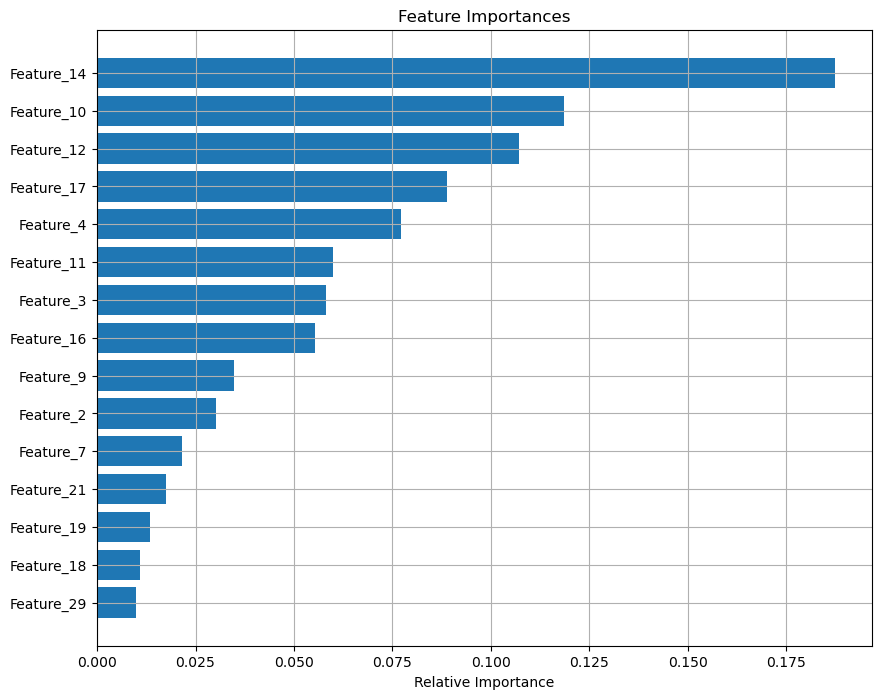

In [6]:
# 특성 중요도 시각화
def plot_feature_importance(model, feature_names, top_n=15):
    """
    랜덤 포레스트 모델의 특성 중요도를 시각화하는 함수
    
    Args:
        model: 학습된 랜덤 포레스트 모델
        feature_names: 특성 이름 리스트
        top_n: 표시할 상위 특성 수
    """
    # 특성 중요도 추출
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # 상위 N개 특성만 선택
    top_indices = indices[:top_n]
    top_importances = importances[top_indices]
    top_feature_names = [feature_names[i] for i in top_indices]
    
    plt.figure(figsize=(10, 8))
    plt.title('Feature Importances')
    plt.barh(range(len(top_indices)), top_importances, align='center')
    plt.yticks(range(len(top_indices)), top_feature_names)
    plt.xlabel('Relative Importance')
    plt.gca().invert_yaxis()  # 중요도가 높은 항목을 위쪽에 표시
    plt.grid(True)
    plt.show()

# 특성 중요도 시각화 (학습이 성공적으로 완료된 경우)
if 'error' not in results['rf']:
    # 특성 이름이 없는 경우 번호로 대체
    feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]
    plot_feature_importance(results['rf']['model'], feature_names)

In [7]:
# 모델 평가
def evaluate_model(model, X_test, y_test):
    """
    학습된 랜덤 포레스트 모델 평가 함수
    
    Args:
        model: 학습된 랜덤 포레스트 모델
        X_test: 테스트 데이터
        y_test: 테스트 레이블
        
    Returns:
        dict: 평가 지표들을 포함한 딕셔너리
    """
    # 예측 확률 계산
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 다양한 임계값에서의 성능 평가
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    results = []
    
    print("Threshold optimization:")
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # 혼동 행렬 계산
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
        
        # 평가 지표 계산
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        spec = tn / (tn + fp) if (tn + fp) else 0.0
        gmean = (rec * spec) ** 0.5
        
        results.append({
            'threshold': threshold,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'specificity': spec,
            'gmean': gmean,
            'confusion_matrix': {
                'tn': int(tn),
                'fp': int(fp),
                'fn': int(fn),
                'tp': int(tp)
            }
        })
        
        print(f"  T={threshold:.1f}: Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} "
              f"F1={f1:.3f} G-Mean={gmean:.3f}")
    
    # AUC-ROC 점수 계산
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # G-Mean 기준으로 최적의 임계값 찾기
    best_result = max(results, key=lambda x: x['gmean'])
    
    print("\nRESULTS SUMMARY:")
    print(f"  AUC-ROC Score: {auc:.4f}")
    print(f"  Best Threshold: {best_result['threshold']:.1f} (G-Mean: {best_result['gmean']:.3f})")
    print(f"  Best Performance: Acc={best_result['accuracy']:.3f}, "
          f"Prec={best_result['precision']:.3f}, Rec={best_result['recall']:.3f}, "
          f"F1={best_result['f1_score']:.3f}")
    
    # 최적의 임계값에서의 혼동 행렬
    cm = best_result['confusion_matrix']
    print(f"\nConfusion Matrix at threshold={best_result['threshold']:.1f}:")
    print(f"  True Negative: {cm['tn']}, False Positive: {cm['fp']}")
    print(f"  False Negative: {cm['fn']}, True Positive: {cm['tp']}")
    
    return {
        'auc': auc,
        'best_threshold': best_result['threshold'],
        'best_metrics': best_result,
        'all_results': results
    }

# 모델 평가 (학습이 성공적으로 완료된 경우)
if 'error' not in results['rf']:
    eval_results = evaluate_model(results['rf']['model'], X_test, y_test)
    results['rf']['evaluation'] = eval_results

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Threshold optimization:
  T=0.1: Acc=0.821 Prec=0.744 Rec=0.979 F1=0.845 G-Mean=0.806
  T=0.2: Acc=0.874 Prec=0.814 Rec=0.968 F1=0.885 G-Mean=0.869
  T=0.3: Acc=0.947 Prec=0.947 Rec=0.947 F1=0.947 G-Mean=0.947
  T=0.4: Acc=0.953 Prec=0.989 Rec=0.916 F1=0.951 G-Mean=0.952
  T=0.5: Acc=0.932 Prec=0.988 Rec=0.874 F1=0.927 G-Mean=0.930
  T=0.6: Acc=0.916 Prec=1.000 Rec=0.832 F1=0.908 G-Mean=0.912
  T=0.7: Acc=0.916 Prec=1.000 Rec=0.832 F1=0.908 G-Mean=0.912
  T=0.8: Acc=0.916 Prec=1.000 Rec=0.832 F1=0.908 G-Mean=0.912
  T=0.9: Acc=0.868 Prec=1.000 Rec=0.737 F1=0.848 G-Mean=0.858

RESULTS SUMMARY:
  AUC-ROC Score: 0.9786
  Best Threshold: 0.4 (G-Mean: 0.952)
  Best Performance: Acc=0.953, Prec=0.989, Rec=0.916, F1=0.951

Confusion Matrix at threshold=0.4:
  True Negative: 94, False Positive: 1
  False Negative: 8, True Positive: 87
  T=0.8: Acc=0.916 Prec=1.000 Rec=0.832 F1=0.908 G-Mean=0.912
  T=0.9: Acc=0.868 Prec=1.000 Rec=0.737 F1=0.848 G-Mean=0.858

RESULTS SUMMARY:
  AUC-ROC Score: 0.

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


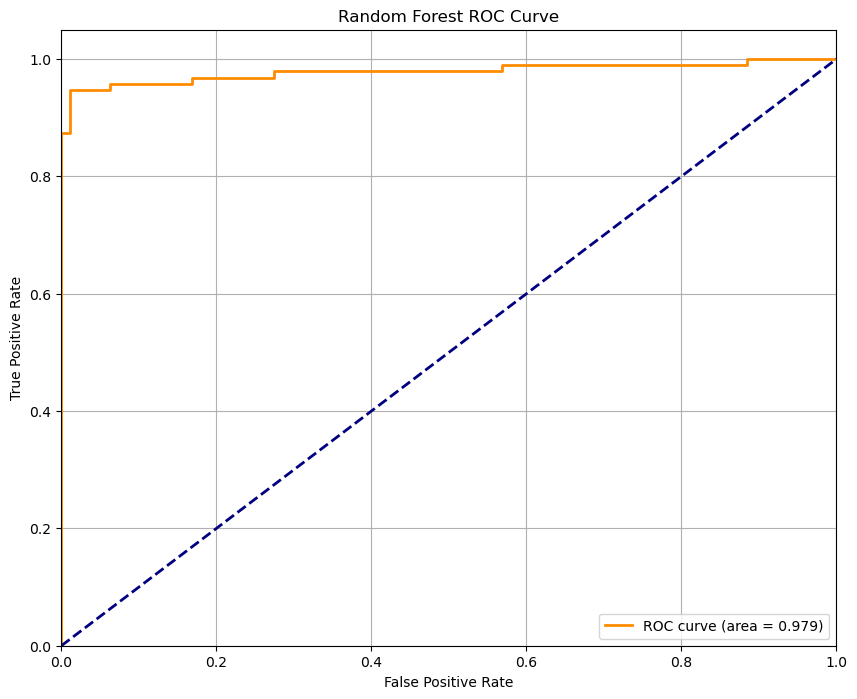

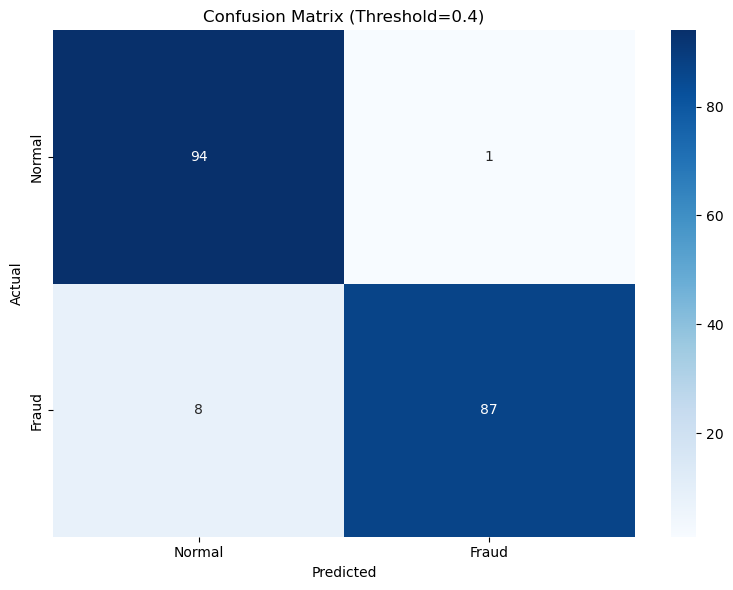

In [8]:
# ROC 곡선 시각화
def plot_roc_curve(y_test, y_scores, title="ROC Curve"):
    """
    ROC 곡선을 시각화하는 함수
    
    Args:
        y_test: 실제 레이블
        y_scores: 예측 확률 또는 점수
        title: 그래프 제목
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# 혼동 행렬 시각화
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    혼동 행렬을 시각화하는 함수
    
    Args:
        y_true: 실제 레이블
        y_pred: 예측 레이블
        labels: 레이블 이름 리스트
        title: 그래프 제목
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels if labels else ['Normal', 'Fraud'],
                yticklabels=labels if labels else ['Normal', 'Fraud'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# ROC 곡선과 최적 임계값에서의 혼동 행렬 시각화
if 'error' not in results['rf'] and 'evaluation' in results['rf']:
    # ROC 곡선
    y_scores = results['rf']['model'].predict_proba(X_test)[:, 1]
    plot_roc_curve(y_test, y_scores, title='Random Forest ROC Curve')
    
    # 최적 임계값에서의 혼동 행렬
    best_threshold = results['rf']['evaluation']['best_threshold']
    y_pred = (y_scores >= best_threshold).astype(int)
    plot_confusion_matrix(y_test, y_pred, title=f"Confusion Matrix (Threshold={best_threshold:.1f})")

In [ ]:
# 하이퍼파라미터 튜닝
def tune_hyperparameters(X_train, y_train, verbose=True):
    """
    랜덤 포레스트 모델의 하이퍼파라미터를 최적화하는 함수 
    
    Args:
        X_train: 훈련 데이터
        y_train: 훈련 레이블
        verbose: 상세 출력 여부
        
    Returns:
        dict: 최적의 파라미터와 모델을 포함한 딕셔너리
    """
    print(f"\n{'='*60}") 
    print("HYPERPARAMETER TUNING")
    print(f"{'='*60}")
    
    # 튜닝 시작 시간 기록
    start_time = time.time()
    
    # 탐색할 파라미터 그리드
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', 'balanced_subsample', None]
    }
    
    # 기본 모델 생성
    base_model = RandomForestClassifier(
        random_state=42,
        n_jobs=1,      # 멀티프로세싱 비활성화로 한글 경로 문제 방지
        verbose=0
    )
    
    # Grid Search 설정
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=3,                    # 3-fold cross-validation
        scoring='f1',            # F1 score for imbalanced classification
        n_jobs=1,                # 멀티프로세싱 비활성화로 한글 경로 문제 방지
        verbose=int(verbose),    
        error_score='raise'      # 오류 발생 시 명확한 예외 처리
    )
    
    # Grid Search 실행
    try:
        grid_search.fit(X_train, y_train)
    except Exception as e:
        print(f"Grid Search 실행 중 오류 발생: {str(e)}")
        print("단순화된 파라미터 그리드로 재시도합니다...")
        
        # 축소된 파라미터 그리드로 재시도
        simplified_param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [10, 15],
            'class_weight': ['balanced', None]
        }
        
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=simplified_param_grid,
            cv=3,
            scoring='f1',
            n_jobs=1,
            verbose=int(verbose),
            error_score='raise'
        )
        
        grid_search.fit(X_train, y_train)
    
    # 튜닝 종료 시간과 소요 시간 계산
    tuning_time = time.time() - start_time
    
    if verbose:
        print(f"\n튜닝 완료 시간: {tuning_time:.2f}초")
        print(f"최적 파라미터: {grid_search.best_params_}")
        print(f"최적 교차검증 점수 (F1): {grid_search.best_score_:.3f}")
    
    return {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model': grid_search.best_estimator_,
        'tuning_time': tuning_time,
        'cv_results': grid_search.cv_results_  # 추가 분석을 위한 전체 결과
    }

# 하이퍼파라미터 튜닝은 시간이 많이 소요되므로 기본적으로 비활성화됨
# 활성화하려면 아래 주석을 해제하세요 (현재 활성화됨)

import os
import sys

# 한글 경로 처리를 위한 환경 설정
if os.name == 'nt':  # Windows 환경
    import locale
    locale.setlocale(locale.LC_ALL, '')
    
try:
    print("하이퍼파라미터 튜닝을 시작합니다...")
    tuning_results = tune_hyperparameters(X_train, y_train)
    results['tuning'] = tuning_results
    
    # 튜닝된 모델 평가
    tuned_model = tuning_results['best_model']
    print("튜닝된 모델을 평가합니다...")
    tuned_eval = evaluate_model(tuned_model, X_test, y_test)
    results['tuned_rf'] = {
        'model': tuned_model,
        'evaluation': tuned_eval
    }
    
    print("하이퍼파라미터 튜닝이 성공적으로 완료되었습니다!")
    
    # 원본 모델과 튜닝된 모델 성능 비교
    original_auc = results['rf']['evaluation']['auc']
    tuned_auc = tuned_eval['auc']
    
    print(f"\n성능 비교:")
    print(f"  원본 모델 AUC: {original_auc:.4f}")
    print(f"  튜닝된 모델 AUC: {tuned_auc:.4f}")
    print(f"  개선 정도: {tuned_auc - original_auc:+.4f}")
    
except Exception as e:
    print(f"하이퍼파라미터 튜닝 실패: {str(e)}")
    results['tuning'] = {'error': str(e)}


하이퍼파라미터 튜닝을 시작합니다...

HYPERPARAMETER TUNING
Fitting 3 folds for each of 108 candidates, totalling 324 fits

튜닝 완료 시간: 377.29초
최적 파라미터: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
최적 교차검증 점수 (F1): 0.930
튜닝된 모델을 평가합니다...
Threshold optimization:
  T=0.1: Acc=0.800 Prec=0.721 Rec=0.979 F1=0.830 G-Mean=0.780
  T=0.2: Acc=0.905 Prec=0.867 Rec=0.958 F1=0.910 G-Mean=0.904
  T=0.3: Acc=0.953 Prec=0.978 Rec=0.926 F1=0.951 G-Mean=0.952
  T=0.4: Acc=0.942 Prec=1.000 Rec=0.884 F1=0.939 G-Mean=0.940
  T=0.5: Acc=0.916 Prec=1.000 Rec=0.832 F1=0.908 G-Mean=0.912
  T=0.6: Acc=0.916 Prec=1.000 Rec=0.832 F1=0.908 G-Mean=0.912
  T=0.7: Acc=0.905 Prec=1.000 Rec=0.811 F1=0.895 G-Mean=0.900

튜닝 완료 시간: 377.29초
최적 파라미터: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
최적 교차검증 점수 (F1): 0.930
튜닝된 모델을 평가합니다...
Threshold optimization:
  T=0.1: Acc=0.800 Prec=0.721 Rec=0.979 F1=0.830 G-Mean=0.780
  T=0.2: Acc=0.905 Prec=0.867 R